In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [12]:
res1 = pd.read_csv('../results/runs/052323/results_rf_folfox_OS_comb_052323.csv', index_col=0)
res1.head()

,fold,val_auroc_mean,val_auroc_ci,test_auroc_mean,test_auroc_ci,test_auprc_mean,test_auprc_ci
0,0,0.703313,0.609661236164943-0.7969646508222951,0.886905,0.8678755514862201-0.9059339723233036,0.905775,0.8882221179427128-0.9233282490304378
1,1,0.704070,0.6149711403981853-0.7931693226126627,0.857948,0.8369724291715378-0.8789236150827154,0.873152,0.8531562763757028-0.8931485629428941
2,2,0.703290,0.6086013515976093-0.7979785222249981,0.877414,0.8577083155629391-0.8971189467270096,0.879489,0.8599285307839807-0.8990502603929135
3,3,0.704136,0.6087739906675605-0.799498105133993,0.835585,0.8132748800379472-0.8578960542908818,0.835945,0.8136537494180701-0.8582357262042054
4,4,0.703452,0.6107979378034676-0.7961057873445623,0.837321,0.8151049941871993-0.8595361541381596,0.858477,0.8374960657472262-0.8794577960700553


In [13]:
#get the mean of 'val_auroc_mean'
val_auroc_mean = res1['val_auroc_mean'].mean()
#get the ci of 'val_auroc_mean'
val_auroc_ci = res1['val_auroc_mean'].std()
#get the mean of 'test_auroc_mean'
test_auroc_mean = res1['test_auroc_mean'].mean()
#get the ci of 'test_auroc_mean'
test_auroc_ci = res1['test_auroc_mean'].std()
test_auprc_mean = res1['test_auprc_mean'].mean()
test_auprc_ci = res1['test_auprc_mean'].std()

In [14]:
res_df = pd.DataFrame({'model':'rf', 'val_auroc_mean': [val_auroc_mean], 'val_auroc_ci': [val_auroc_ci], 'test_auroc_mean': [test_auroc_mean], 'test_auroc_ci': [test_auroc_ci], 'test_auprc_mean': [test_auprc_mean], 'test_auprc_ci': [test_auprc_ci]})
res_df

,model,val_auroc_mean,val_auroc_ci,test_auroc_mean,test_auroc_ci,test_auprc_mean,test_auprc_ci
0,rf,0.703652,0.000417,0.859034,0.023114,0.870568,0.02584


In [23]:
today_str = '052323'
model_types = ['rf']
drugs = ['folfox', 'egfr', 'vegf', 'reg']
data_types = ['comb', 'clin', 'mut', 'cna']
outcomes = ['OS', 'PFS']
res_dfs = {}
#for each drug and outcome, create a dataframe with the results for each model type and data type

for drug in drugs:
    for outcome in outcomes:
        res_dfs[str(drug) + '_' + str(outcome)] = pd.DataFrame(columns=['model', 'data_type', 'val_auroc_mean', 'val_auroc_ci', 'test_auroc_mean', 'test_auroc_ci', 'test_auprc_mean', 'test_auprc_ci'])
        count = 0
        for model_type in model_types:
            for data_type in data_types:
                res_file = f'../results/runs/{today_str}/results_{model_type}_{drug}_{outcome}_{data_type}_{today_str}.csv'
                res1 = pd.read_csv(res_file, index_col=0)
                val_auroc_mean = res1['val_auroc_mean'].mean()
                val_auroc_ci = res1['val_auroc_mean'].std()
                test_auroc_mean = res1['test_auroc_mean'].mean()
                test_auroc_ci = res1['test_auroc_mean'].std()
                test_auprc_mean = res1['test_auprc_mean'].mean()
                test_auprc_ci = res1['test_auprc_mean'].std()
                res_dfs[str(drug) + '_' + str(outcome)] = pd.concat([res_dfs[str(drug) + '_' + str(outcome)], pd.DataFrame({'model': [model_type], 'data_type': [data_type], 'val_auroc_mean': [val_auroc_mean], 'val_auroc_ci': [val_auroc_ci], 'test_auroc_mean': [test_auroc_mean], 'test_auroc_ci': [test_auroc_ci], 'test_auprc_mean': [test_auprc_mean], 'test_auprc_ci': [test_auprc_ci]}, index=[count])])
                count += 1


In [27]:
res_dfs['egfr_OS'].head()

,model,data_type,val_auroc_mean,val_auroc_ci,test_auroc_mean,test_auroc_ci,test_auprc_mean,test_auprc_ci
0,rf,comb,0.520923,0.000975,0.860775,0.019693,0.915806,0.015701
1,rf,clin,0.524771,0.004768,0.851790,0.031149,0.909442,0.024799
2,rf,mut,0.525446,0.002608,0.852290,0.023603,0.911223,0.019272
3,rf,cna,0.523899,0.005209,0.849645,0.030255,0.907971,0.023211


In [37]:
#prepare dataframe for plotting with bars and error bars
res_data = res_dfs['folfox_OS'][res_dfs['folfox_OS']['data_type'] == data_type]
res_data = res_data[['model', 'val_auroc_mean', 'val_auroc_ci', 'test_auroc_mean', 'test_auroc_ci']]
ymax = max(res_data['val_auroc_mean'].max(), res_data['test_auroc_mean'].max())
res_data.columns = ['Model', 'Validation', 'Validation CI', 'Test', 'Test CI']
res_data = res_data.melt(id_vars='Model', var_name='Type', value_name='AUROC')
res_data.head()


,Model,Type,AUROC
0,rf,Validation,0.703652
1,rf,Validation CI,0.000417
2,rf,Test,0.859034
3,rf,Test CI,0.023114


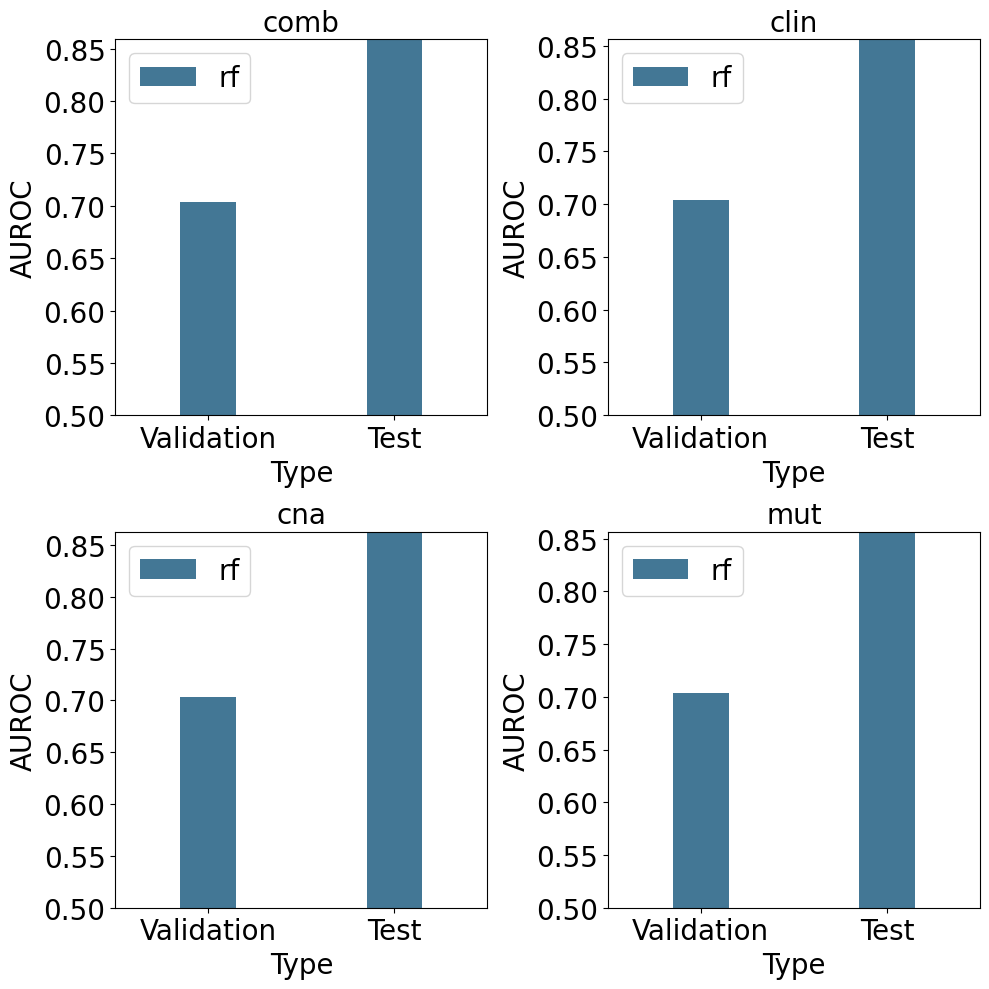

In [41]:
#plot the 4 data types in a 2x2 grid

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i, data_type in enumerate(['comb', 'clin', 'cna', 'mut']):
    res_data = res_dfs['folfox_OS'][res_dfs['folfox_OS']['data_type'] == data_type]
    res_data = res_data[['model', 'val_auroc_mean', 'test_auroc_mean']]
    ymax = max(res_data['val_auroc_mean'].max(), res_data['test_auroc_mean'].max())
    res_data.columns = ['Model', 'Validation', 'Test']
    res_data = res_data.melt(id_vars='Model', var_name='Type', value_name='AUROC')
    #make the size of the bars narrower
    ax = ax.flatten()
    #plot the bars, with error bars for val_auroc_mean from val_auroc_ci and test_auroc_mean from test_auroc_ci
    sns.barplot(x='Type', y='AUROC', hue='Model', data=res_data, errorbar=None, ax=ax[i], palette='mako', width=0.3)
    
    ax[i].set_title(f'{data_type}')
    ax[i].set_ylim(0.5, ymax)
    #make the font bigger
    for item in ([ax[i].title, ax[i].xaxis.label, ax[i].yaxis.label] + ax[i].get_xticklabels() + ax[i].get_yticklabels()):
            item.set_fontsize(20)
    ax[i].legend(fontsize=20)
plt.tight_layout()
plt.show()


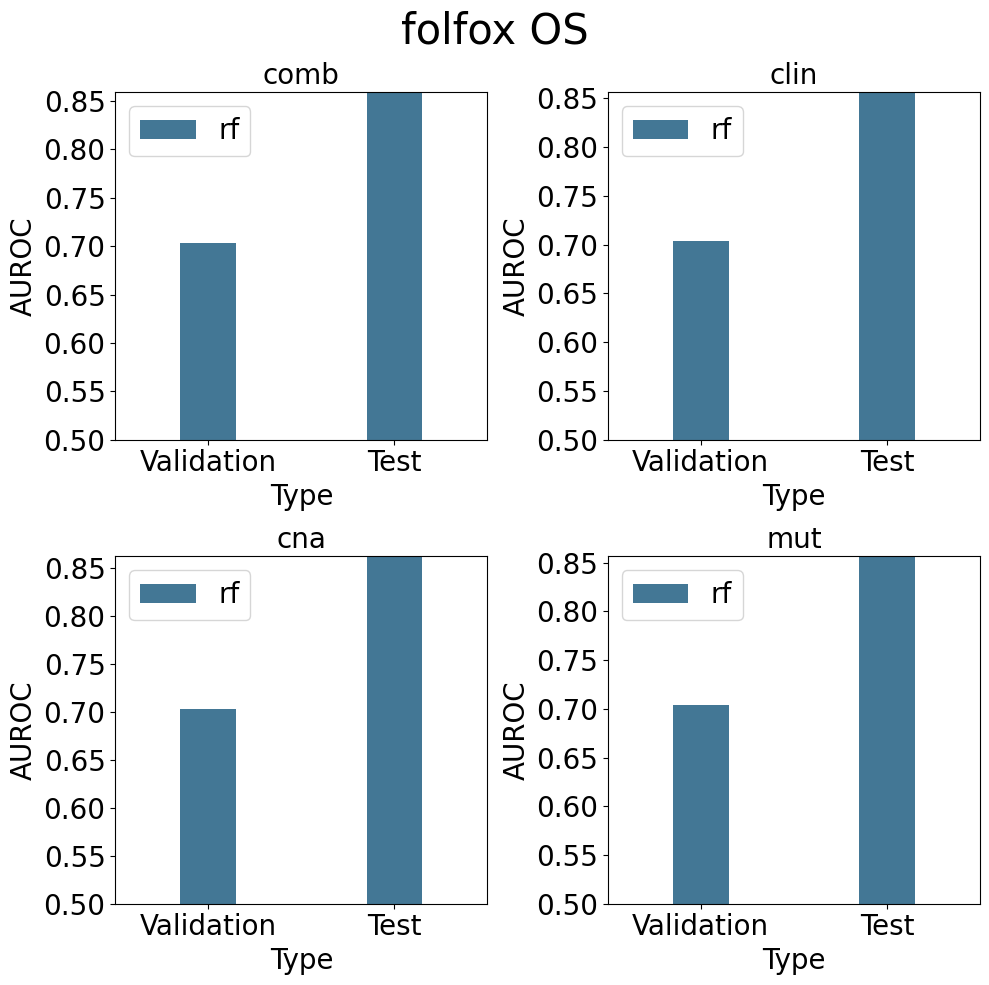

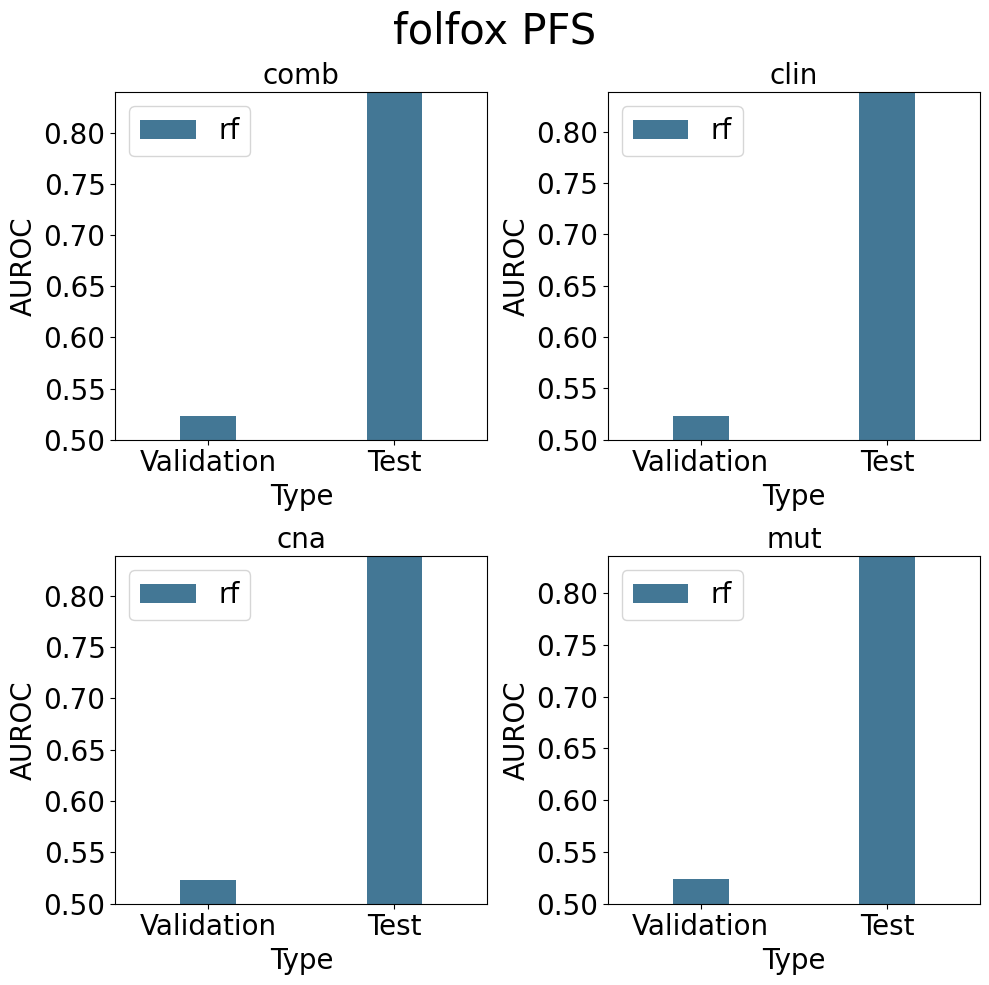

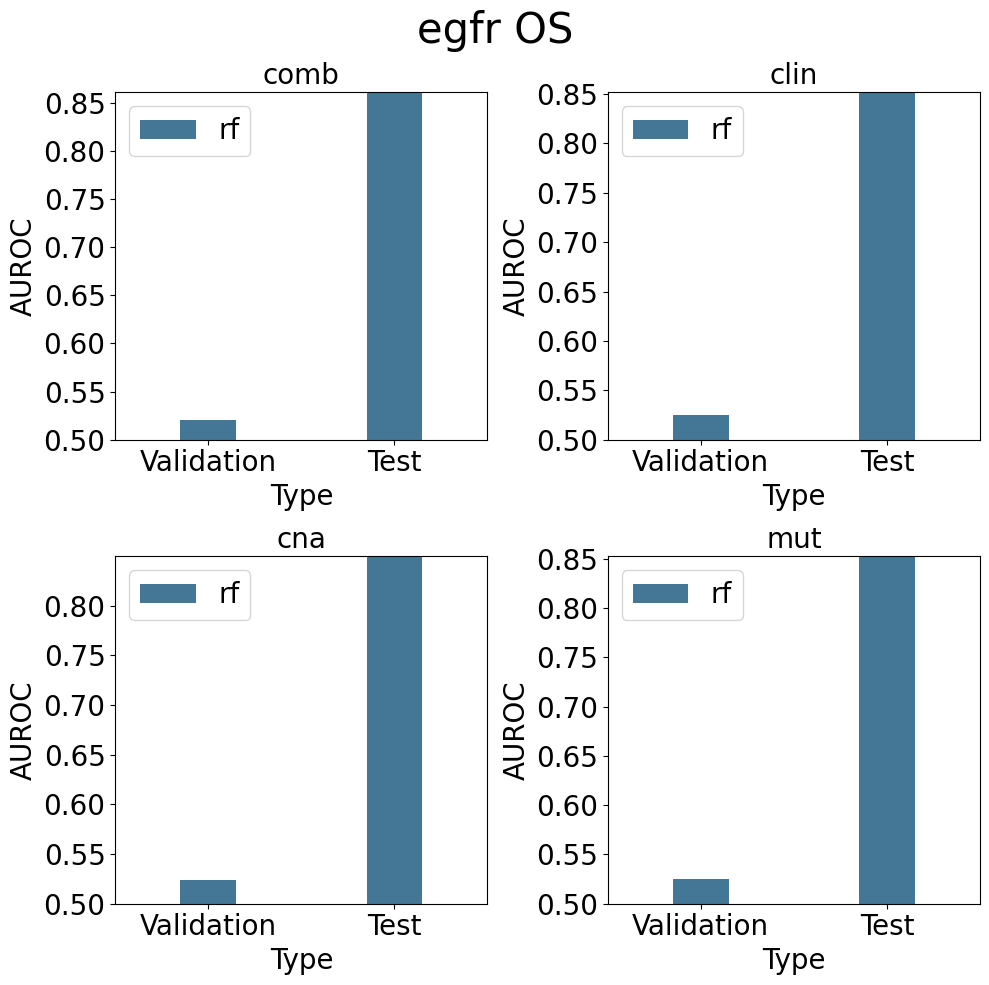

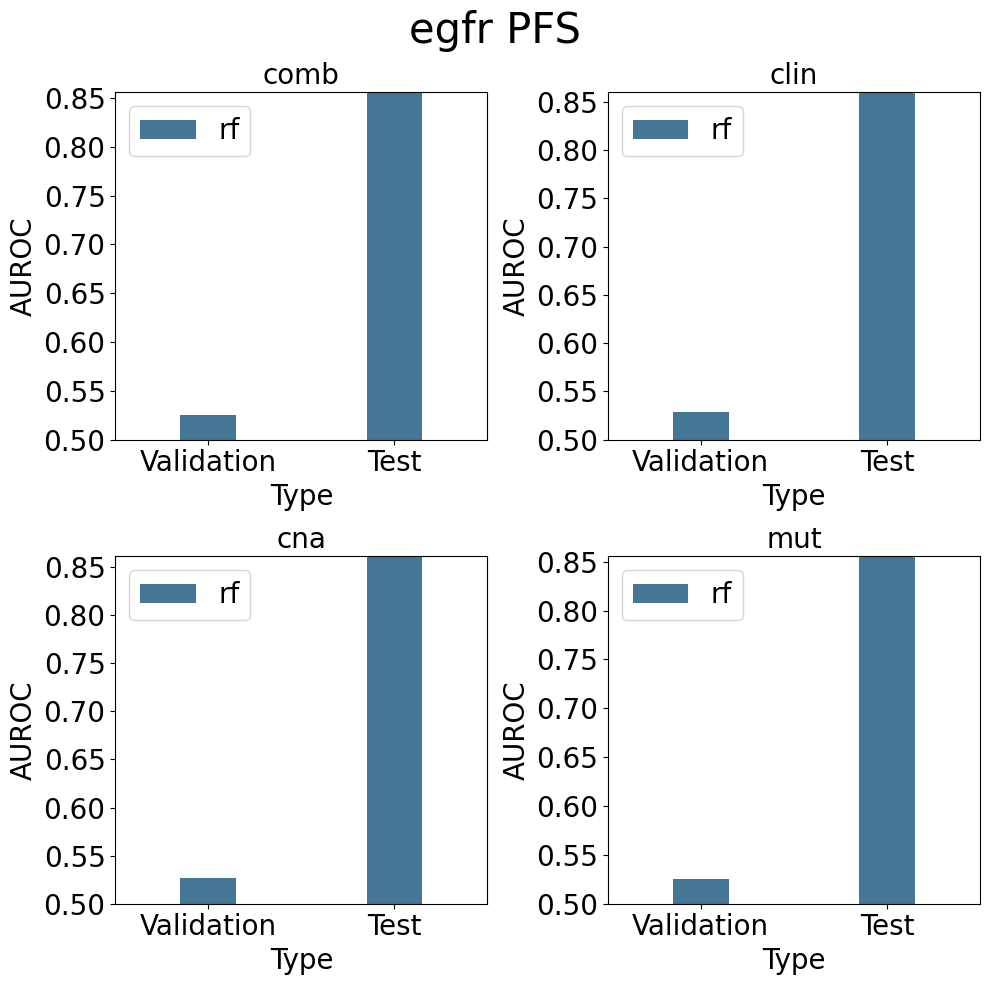

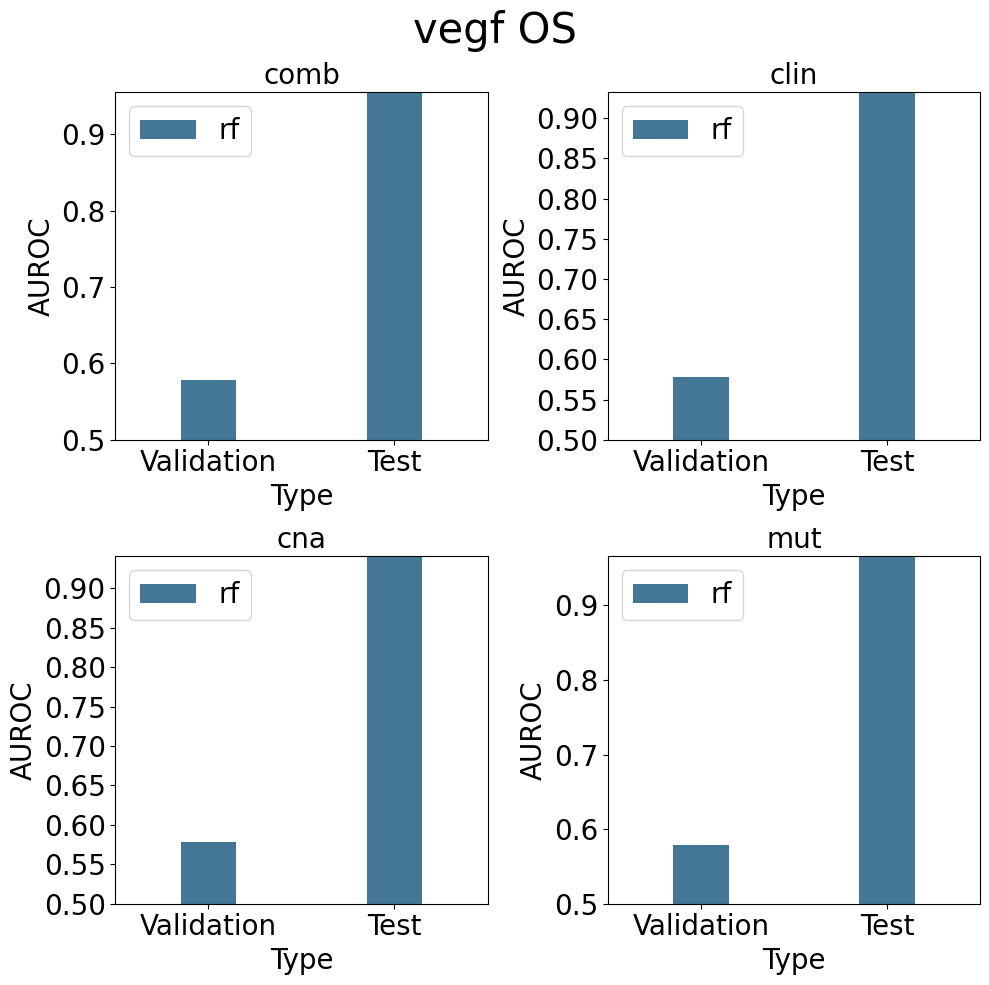

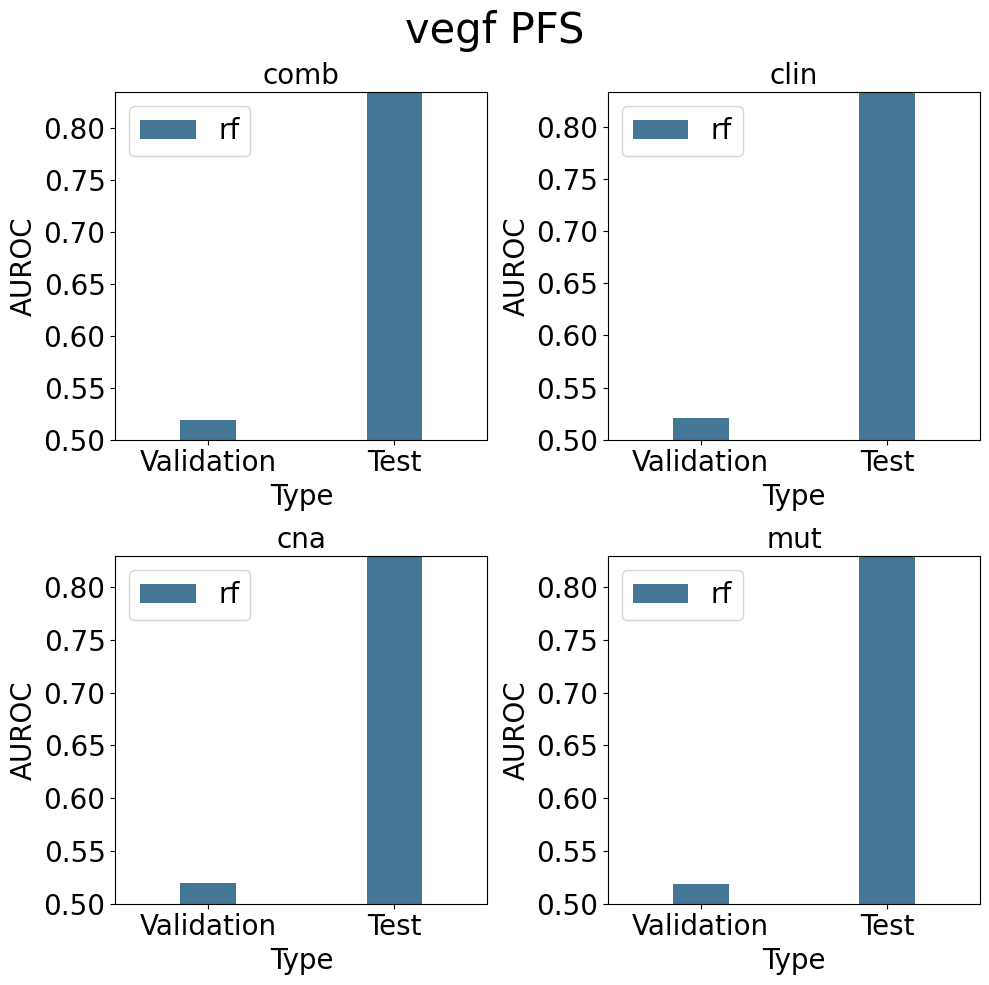

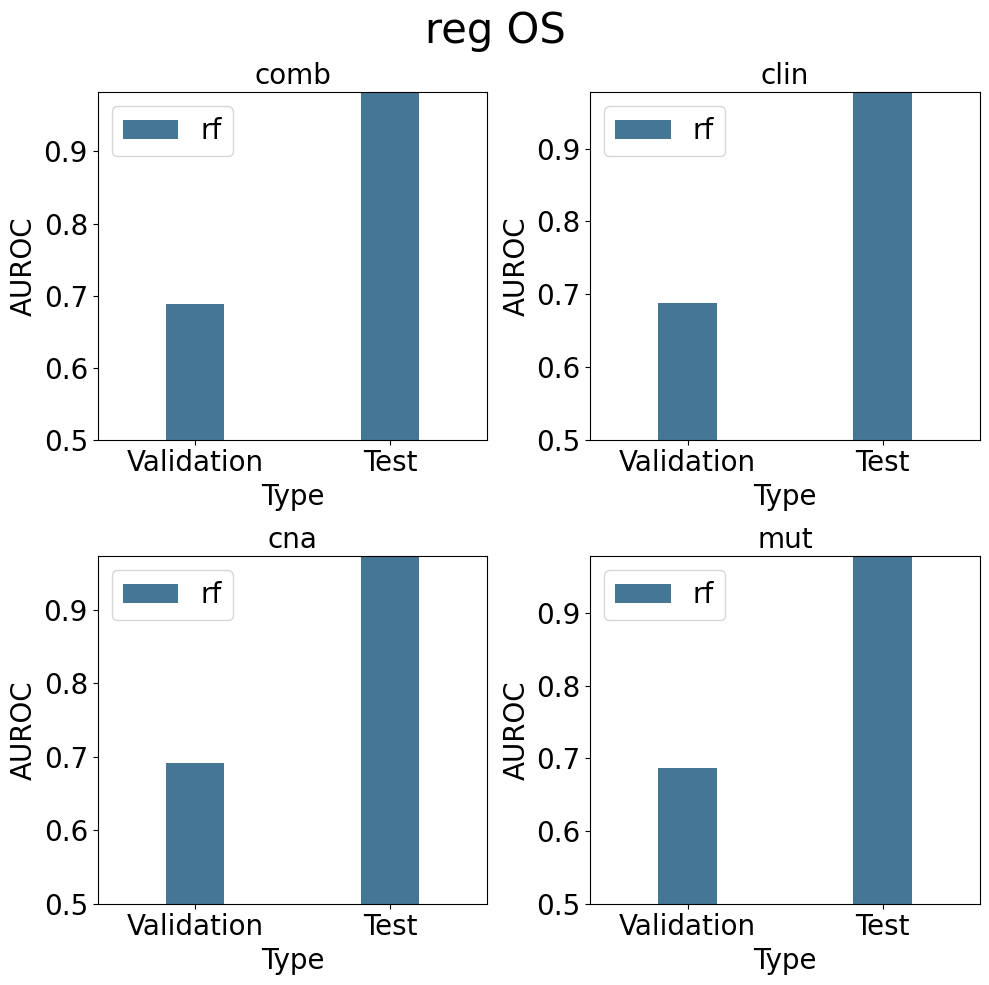

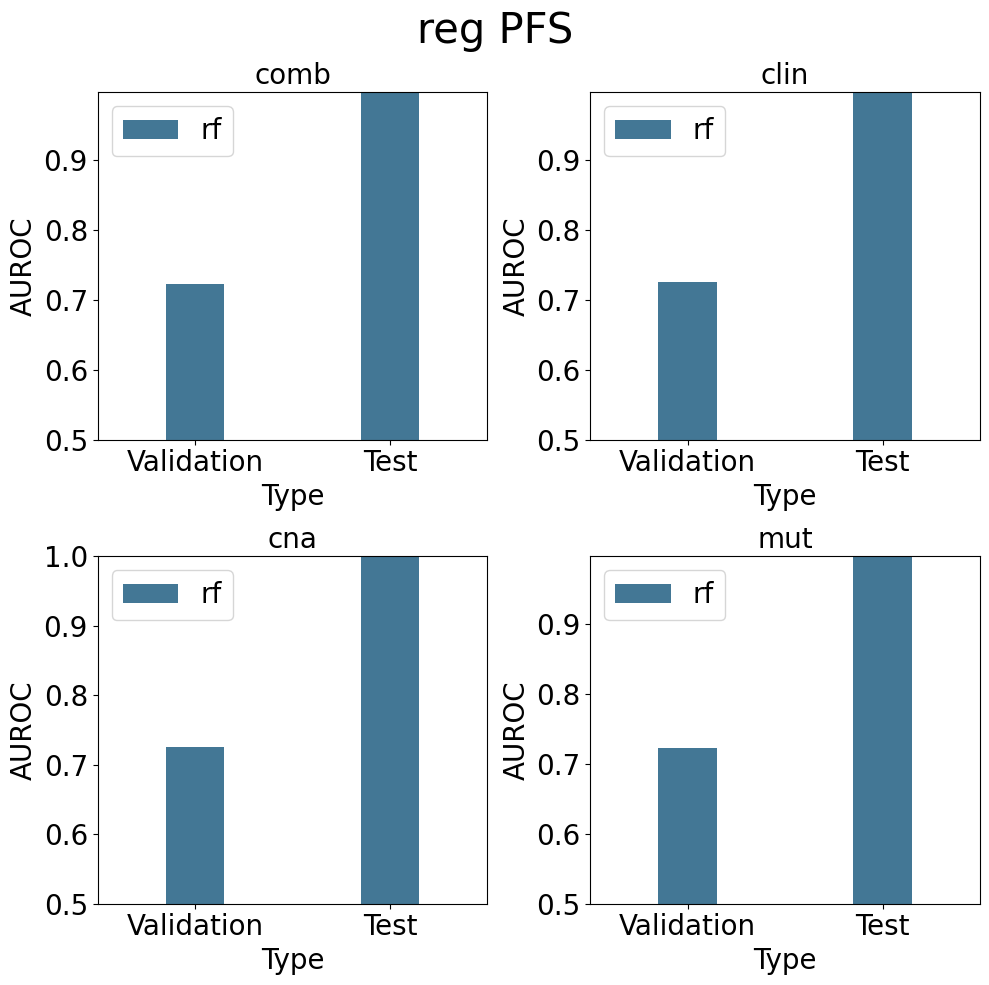

In [43]:
for drug in drugs:
        for outcome in outcomes:
                
                fig, ax = plt.subplots(2, 2, figsize=(10, 10))
                for i, data_type in enumerate(['comb', 'clin', 'cna', 'mut']):
                        res_data = res_dfs[f'{drug}_{outcome}'][res_dfs[f'{drug}_{outcome}']['data_type'] == data_type]
                        res_data = res_data[['model', 'val_auroc_mean', 'test_auroc_mean']]
                        ymax = max(res_data['val_auroc_mean'].max(), res_data['test_auroc_mean'].max())
                        res_data.columns = ['Model', 'Validation', 'Test']
                        res_data = res_data.melt(id_vars='Model', var_name='Type', value_name='AUROC')
                        #make the size of the bars narrower
                        ax = ax.flatten()
                        #plot the bars, with error bars for val_auroc_mean from val_auroc_ci and test_auroc_mean from test_auroc_ci
                        sns.barplot(x='Type', y='AUROC', hue='Model', data=res_data, errorbar=None, ax=ax[i], palette='mako', width=0.3)
                        
                        ax[i].set_title(f'{data_type}')
                        ax[i].set_ylim(0.5, ymax)
                        #make the font bigger
                        for item in ([ax[i].title, ax[i].xaxis.label, ax[i].yaxis.label] + ax[i].get_xticklabels() + ax[i].get_yticklabels()):
                                item.set_fontsize(20)
                        ax[i].legend(fontsize=20)
                        fig.suptitle(f'{drug} {outcome}', fontsize=30)
                plt.tight_layout()
                plt.show()